## Neural network playing ground (Small Methods Imgs)
### Nov 2023 - Code by Mauricio Cano Galván

Library Import

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from nn_backend.import_xyz_img import import_xyz_img
from nn_backend.conv_imgs import conv_imgs
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import cm, colormaps
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.optimizers import Adam
from keras.utils import set_random_seed
from scipy.stats import norm
import seaborn as sns
import math
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from nn_backend.modified_loss_functions import cube_msle, linear_msle
from skimage import morphology
from nn_backend.data_import import import_curves_from_folder, curve_calibration, matrix_cut, data_augment, mask_from_topo
from nn_backend.nn_for_ep import nn_for_ep
from nn_backend.post_process import prediction_reconstruction_with_train, img_export, histogram_export



viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 0.1])
white = np.array([251/255, 252/255, 159/255, 1])
newcolors[0:33, :] = black
newcolors[33:, :] = white
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

In [292]:
#Constant Setup
pctg=3


cutout_size=9

#Graphics (1 to show images, 0 to not)
kernel_visualization=0 
input_imgs_view=1
train_curve=0

#NN Setup
kernel_dim=3
iterations=300
batch_sz=200

#Other parameters
#topo_area_dim=9
use_last_curves=1

name='efm8'
curves_file=r'c:\Users\mcano\Code\rawdata\preprocessed curves\efm8_curves_calibrated.npy'
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM8\Topography Flattened EFM8_mirror.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\EFM8\Map_Nanofilament_mirror.txt"
raw_curves_folder=0
curves_max_limit=1000
calibrate_curves=1
nu_dim=118
ref_flip=0
topo_flip=1

Data Import

In [293]:
#Curve import
if not raw_curves_folder:
    curves_projected=pd.DataFrame(np.load(rf'{curves_file}'))
    curves_projected=curves_projected.interpolate(axis=1)
    curves_projected=curves_projected.bfill(axis=1)
else:
    curves_projected, m_vec=import_curves_from_folder(curves_file)

    if calibrate_curves:
        K=0.718
        G=200
        uac=3
        curves_projected=curve_calibration(curves_projected, m_vec, K, G, uac)



In [294]:
#curves_name=rf'efm9_curves_calibrated'
#np.save('{curves_name}.npy', curves_projected)

In [295]:
#------Import the label data (εp map), as a matrix first and then transformed into a DataFrame.------#
#----------The data is then cleaned to remove outliers
y_mat, ax_ep, ay_ep= import_xyz_img(ref_file)
if ref_flip:
    y_mat=np.flipud(y_mat)
y_mat=matrix_cut(y_mat,nu_dim)
y=pd.DataFrame(np.reshape(y_mat,nu_dim**2))
#------Manual noise removal in label *ONLY FOR EFM9*------#

#Logarithmic sampling
maxlen=1713
curve_height_setpoint=20
curve_nsamples=12

zs=np.round((np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint)).astype(int)
samples = []
[samples.append(x) for x in zs if x not in samples]


#New curves
curves=(np.array(curves_projected)).reshape(128,128,len(curves_projected.iloc[0,:]))
curves=matrix_cut(curves, nu_dim)
curves_sampled=curves[:,:,samples]

#Topography import
T_mat, x, y2 = import_xyz_img(topography_file)
if topo_flip:
    T_mat=np.flipud(T_mat)
T_mat=matrix_cut(T_mat, nu_dim)
T_mat=np.expand_dims(T_mat, axis=2)
T=T_mat.reshape(nu_dim**2)
#Put together training dataset
X_mat=np.concatenate((T_mat, curves_sampled), axis=2)

aa=["Z = "+str(x)+" nm" for x in samples]
inputs=["Topography"]
inputs=np.append(inputs, aa)

X=np.reshape(X_mat,(nu_dim**2,len(X_mat[0,0,:])))
X=pd.DataFrame(X, columns=inputs)



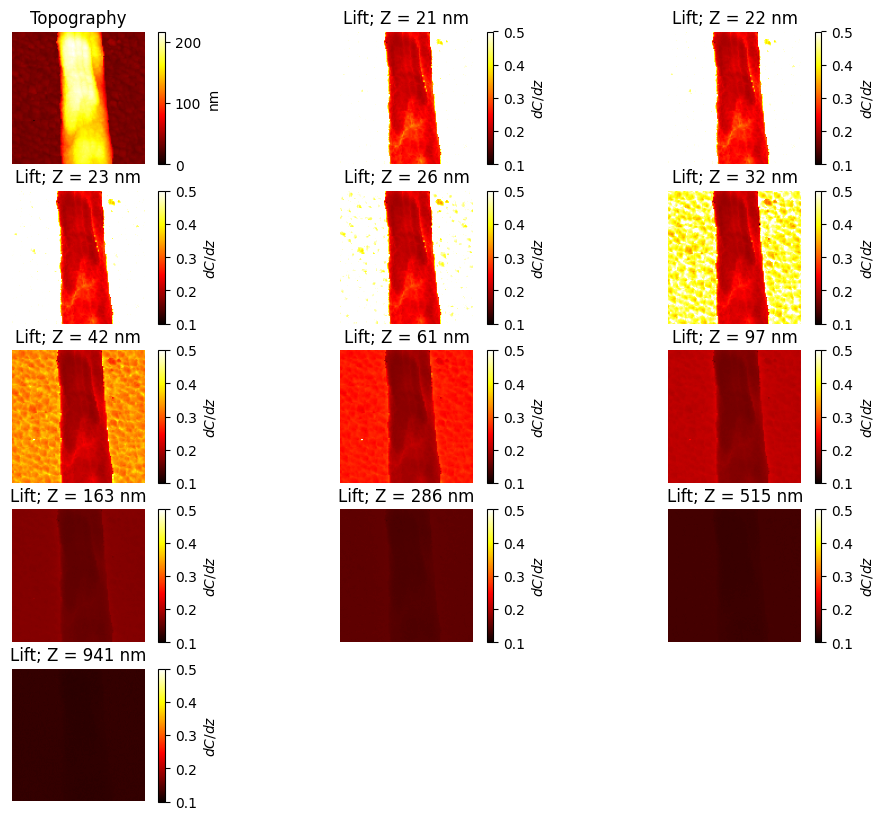

In [296]:
if input_imgs_view:
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(5,3,1)
    pcm=ax.imshow(X_mat[:,:,0], cmap='hot')
    ax.set_title("Topography")
    plt.colorbar(pcm, label="nm")
    ax.axis('off')
    for i in range(2,14):
        ax=fig.add_subplot(5,3,i)
        pcm=ax.imshow(X_mat[:,:,i-1], cmap='hot', vmin=0.1, vmax=0.5)
        h=samples[i-2]
        ax.set_title("Lift; Z = "+str(h)+" nm")
        plt.colorbar(pcm, label="$dC/dz$")
        ax.axis('off')
     

Data Pre-Processing

C:\Users\mcano\AppData\Local\Temp\ipykernel_10248\825626241.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))


Text(0.5, 1.0, 'Final Train Mask')

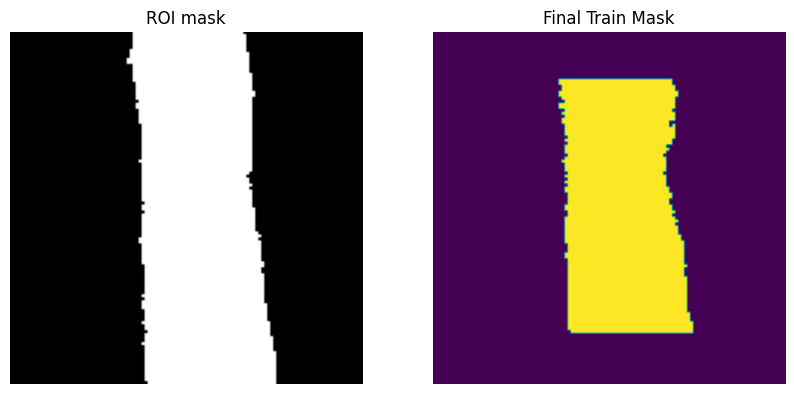

In [297]:
#EFM9: binary_threshold=0.04, object_size=3, hole_size=30, m_thresh=0.30
#EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
#EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
#EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785

binary_threshold=0.41
object_size=3
hole_size=30
m_ep_thresh=0.77

bin=mask_from_topo(T,binary_threshold,object_size,hole_size)

cell=bin.reshape(nu_dim**2,1)
roi_index=pd.DataFrame(copy(cell))
roi_index=roi_index.index[(roi_index[0])]


mask_ep=pd.DataFrame(copy(y))
th=float(mask_ep.quantile(m_ep_thresh))

mask_ep[(mask_ep[0]<=th)]=0
mask_ep[(mask_ep[0]!=0)]=1
mask_ep=cell*mask_ep
mask_ep_im=np.reshape(np.array(mask_ep), ((nu_dim),(nu_dim)))

cell_index=mask_ep.index[mask_ep[0]>0].tolist()


fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(1,2,1)
ax.imshow(bin, cmap='gray')
ax.set_title('ROI mask')
ax.axis('off')
ax=fig.add_subplot(1,2,2)
ax.imshow(mask_ep_im)
ax.axis('off')
ax.set_title('Final Train Mask')


In [298]:
#------Cell separation------#
y_cell=pd.DataFrame(y.iloc[cell_index])
X_cell=pd.DataFrame(X.iloc[cell_index])
y_roi=pd.DataFrame(y.iloc[roi_index])
X_roi=pd.DataFrame(X.iloc[roi_index])


#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)
Xn_roi=pd.DataFrame(curve_scale.transform(X_roi), columns=inputs)

In [299]:

#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)

In [300]:

topo_mat, x, y2 = import_xyz_img(topography_file)
if topo_flip:
    topo_mat=np.flipud(topo_mat)
topo=topo_mat.reshape(len(topo_mat)**2,1)

topo_scale=StandardScaler()
topo_scale.fit(topo)
topo_n=topo_scale.transform(topo)
topo_n_mat=topo_n.reshape(len(topo_mat),len(topo_mat),1)

Cv_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size)
Cv_mat=Cv_mat.reshape(int(math.sqrt(len(Cv_mat))),int(math.sqrt(len(Cv_mat))),cutout_size,cutout_size)
Cv_mat=matrix_cut(Cv_mat, nu_dim)
Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
Cv_mat=np.expand_dims(Cv_mat, axis=-1)



Cv_cell_mat=Cv_mat[cell_index,:,:,:]
Cv_roi_mat=Cv_mat[roi_index,:,:,:]


  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:24<00:00,  4.88it/s]


In [301]:
Xn_train_input=pd.DataFrame(Xn_cell)
y_train_input=pd.DataFrame(y_cell)
Cv_train_input=Cv_cell_mat

Test-Train Separation

In [302]:

sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(Xn_train_input, y_train_input)
train_index, test_index = next(sss.split(Xn_train_input, y_train_input))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = Xn_train_input.iloc[train_index], Xn_train_input.iloc[test_index] 
y_train, y_test = y_train_input.iloc[train_index], y_train_input.iloc[test_index]

Cv_train, Cv_test = Cv_train_input[train_index,:,:], Cv_train_input[test_index,:,:] 
Cv_train_aug=data_augment(Cv_train)


N_aug=int(len(Cv_train_aug[:,0,0,0])/len(Cv_train[:,0,0,0]))

X_train_aug=copy(X_train)
y_train_aug=copy(y_train)
for i in np.arange(N_aug-1):
    X_train_aug=pd.DataFrame(np.concatenate((X_train_aug, X_train), axis=0))
    y_train_aug=pd.DataFrame(np.concatenate((y_train_aug, y_train), axis=0))

Network Architecture

In [303]:
#------Example Keras Network------#
reg, histo=nn_for_ep(X_train_aug,Cv_train_aug,y_train_aug,X_test,Cv_test,y_test, verb=1)

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 1.6582 - mae: 1.8838 - val_loss: 0.0496 - val_mae: 0.5158
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0550 - mae: 0.6100 - val_loss: 0.1703 - val_mae: 1.4785
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1909 - mae: 1.6058 - val_loss: 0.0731 - val_mae: 0.8216
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0651 - mae: 0.7628 - val_loss: 0.0293 - val_mae: 0.3916
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0310 - mae: 0.3974 - val_loss: 0.0530 - val_mae: 0.5595
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0372 - mae: 0.4580 - val_loss: 0.0193 - val_mae: 0.3235
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0159 - mae: 0.3122 - val_loss: 0.0187 - val_mae: 0.3526
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0231 - mae: 0.4294 - val_loss: 0.0156 - val_mae: 0.3152
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0159 - mae:

Results

In [304]:
res=reg.predict([Xn_roi, Cv_roi_mat])

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Results visualization

0.9375


C:\Users\mcano\AppData\Local\Temp\ipykernel_10248\3248370411.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_roi[roi_index[i]]=res[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_10248\3248370411.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_cell[cell_index[i]]=res_cell[i]


The error map presents 13 error values > 1 (0.41%)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Resultado de red neuronal (train data=3%)')

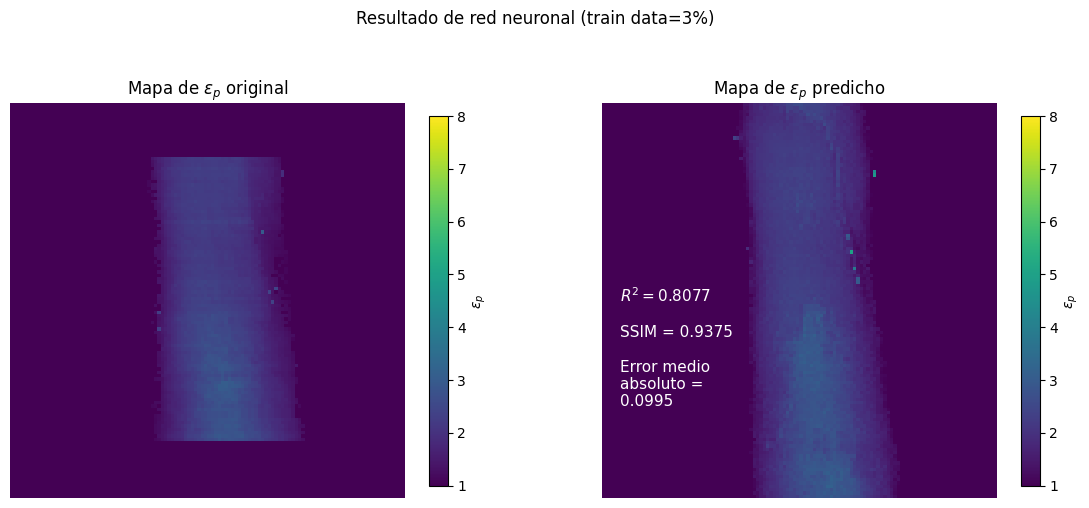

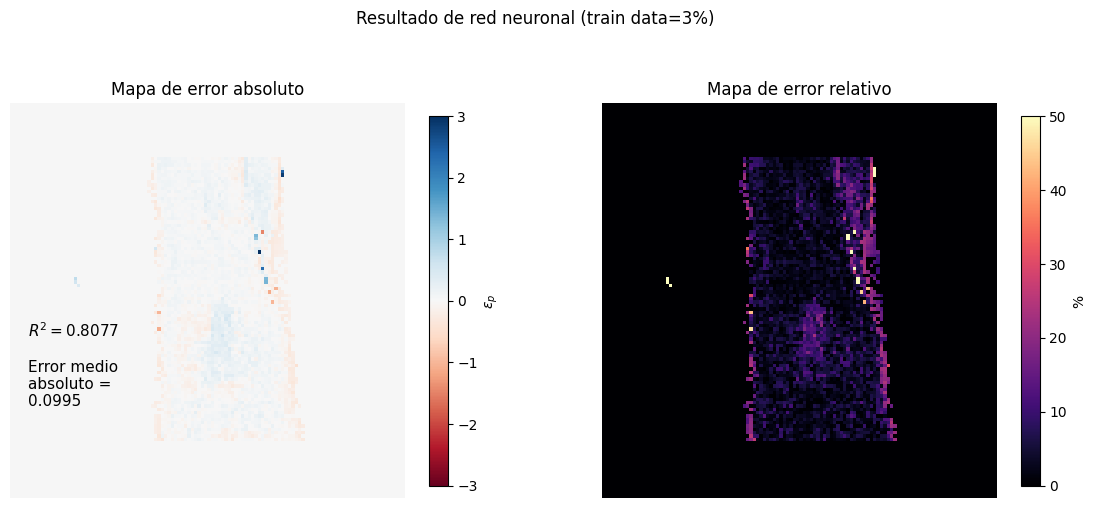

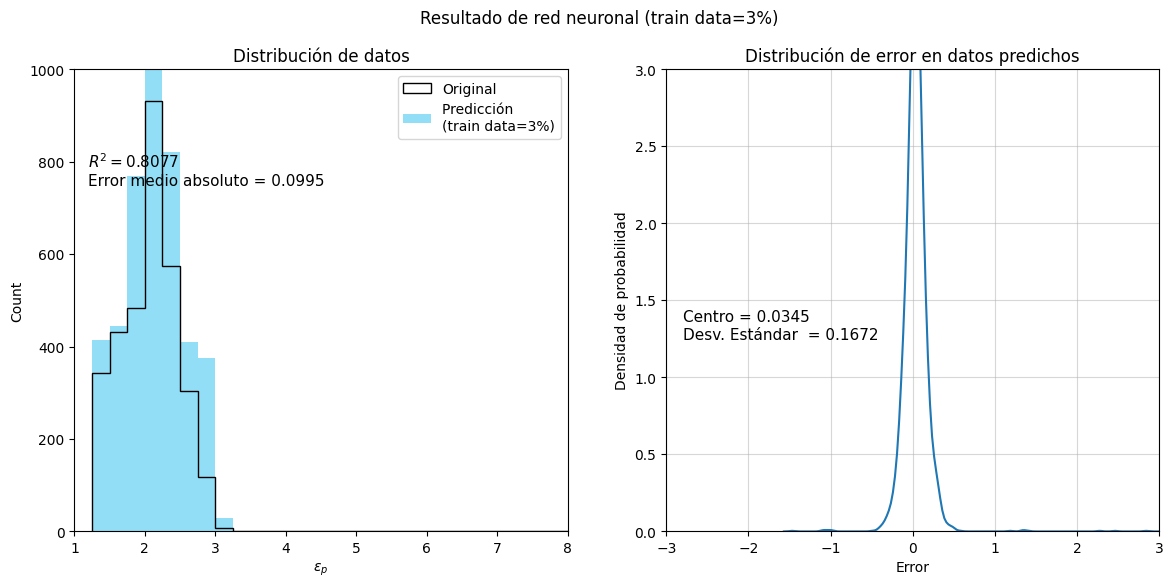

<Figure size 640x480 with 0 Axes>

In [305]:
full_vec_roi=np.zeros(nu_dim**2)+1
for i in np.arange(len(roi_index)):
    full_vec_roi[roi_index[i]]=res[i]



'''for i in y.index[np.array(cell_index)[train_index]]:
    full_vec_roi[i]=y.iloc[i]'''

full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))
full_vec_roi=pd.DataFrame(full_vec_roi)
full_roi=copy(full_vec_roi)
full_cell=pd.DataFrame(full_roi.iloc[roi_index])

#Metrics calculations
res_cell=np.array(full_vec_roi.iloc[cell_index])
full_vec_cell=np.zeros(nu_dim**2)+1
for i in np.arange(len(cell_index)):
    full_vec_cell[cell_index[i]]=res_cell[i]
full_img_cell=np.reshape(full_vec_cell,(nu_dim,nu_dim))

error_map=np.subtract(full_img_cell,y_mat)
error_map_r=(abs(np.subtract(y_mat, full_img_cell))/y_mat)*100

from skimage.metrics import structural_similarity as ssim

ssim = np.round(ssim(y_mat, full_img_cell, data_range=full_img_cell.max() - full_img_cell.min()), decimals=4)
print(ssim)

rsqr_cell=np.round(r2_score(y_cell, res_cell), decimals=4)
mae_cell=mean_absolute_error(y_cell, res_cell)


fig1=plt.figure(figsize=(14,6))

ax=fig1.add_subplot(1,2,1)
pcm=ax.imshow(y_mat, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ original")


ax=fig1.add_subplot(1,2,2)
pcm=ax.imshow(full_img_roi, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ predicho")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nSSIM = "+str(ssim)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#fff")

fig1.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig2=plt.figure(figsize=(14,6))

ax=fig2.add_subplot(1,2,1)
pcm=ax.imshow(error_map, cmap="RdBu", vmin=-3, vmax=3)
ax.set_title("Mapa de error absoluto")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_p$")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")

ax=fig2.add_subplot(1,2,2)
pcm=ax.imshow(error_map_r, cmap="magma", vmin=0, vmax=50)
ax.set_title("Mapa de error relativo")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="%")


fig2.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig3=plt.figure(figsize=(14,6))

ax=fig3.add_subplot(1,2,1)
binss=(np.arange(32)*0.25)+1.25
xaxis=(np.arange(9))
ax.hist(y_cell, histtype="step", color="#000",bins=binss)
ax.hist(full_cell, histtype="bar", color="#92def7",bins=binss)
ax.set_xticks(xaxis)
ax.set_xlim([1,8])
ax.set_ylim([0,1000])
ax.set_title("Distribución de datos")
ax.legend(["Original","Predicción \n(train data="+str(pctg)+"%)"])
ax.set_xlabel("$ε_{p}$")
ax.set_ylabel("Count")
ax.text(1.2, 750, "$R^2 = $"+str(rsqr_cell)+"\nError medio absoluto = "+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")



thresh=1
print("The error map presents "+str(len(error_map[abs(error_map)>thresh]))+" error values > "+str(thresh)+" ("+str(np.round((len(error_map[abs(error_map)>thresh])/len(y_cell))*100, decimals=2))+"%)")
plt.figure()
err=pd.DataFrame(np.subtract(res_cell,y_cell))
ax=fig3.add_subplot(1,2,2)
ax = sns.kdeplot(data=err, ax=ax)
legend=ax.legend()
legend.remove()
ax.set_title("Distribución de error en datos predichos")
ax.set_xlabel("Error")
ax.set_ylabel("Densidad de probabilidad")
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.grid('on', alpha=0.5)
err_mean, err_std=norm.fit(err)
ax.text(-2.8, 1.25, "Centro = "+str(np.round(err_mean, decimals=4))+"\nDesv. Estándar  = "+str(np.round(err_std, decimals=4)), fontsize=11, color="#000")

fig3.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")


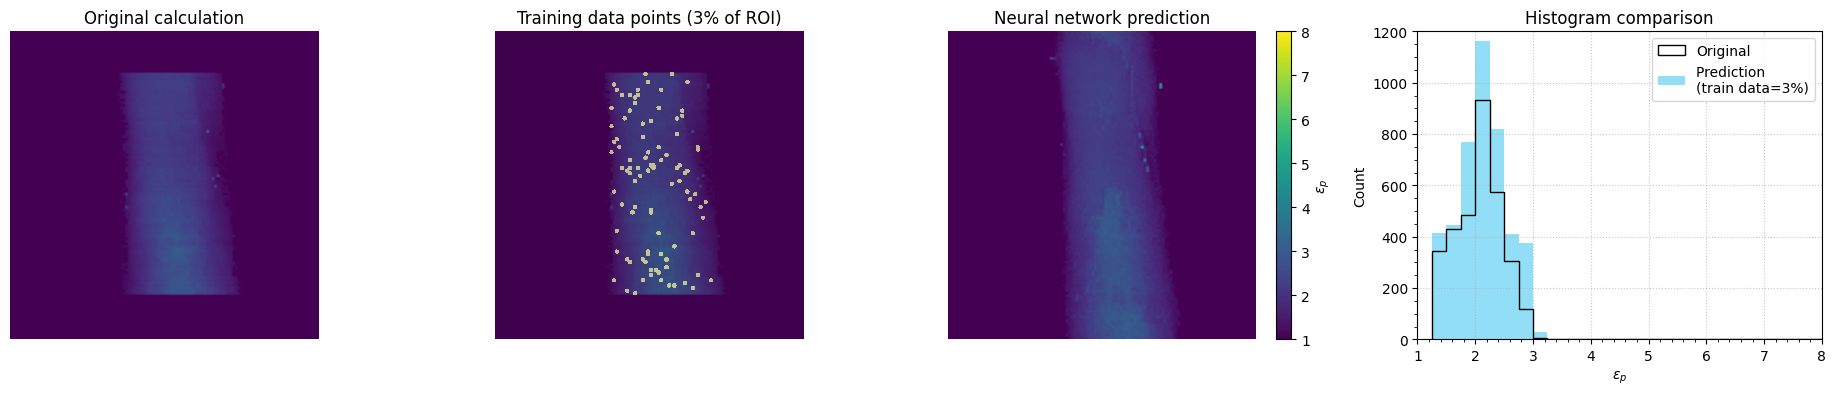

In [309]:
mapp=list(np.zeros((nu_dim**2)))
train_index_for_full_cell=np.array(cell_index)[train_index]
mapp=[y.iloc[i,0] if i in train_index_for_full_cell else 0 for i in range(len(mapp))]
mapp=np.array(mapp).reshape(nu_dim,nu_dim)

fig=plt.figure(figsize=(24,4))
ax=fig.add_subplot(1,4,1)
ax.imshow(y_mat, vmin=1, vmax=8)
ax.set_title('Original calculation')
ax.axis('off')

ax=fig.add_subplot(1,4,2)
ax.imshow(y_mat, vmin=1, vmax=8)
ax.imshow(mapp, cmap=newcmp, vmin=-1, vmax=8, alpha=0.7)
ax.set_title(f'Training data points ({pctg}% of ROI)')
ax.axis('off')


ax=fig.add_subplot(1,4,3)
pcm=ax.imshow(full_img_roi, vmin=1, vmax=8)
ax.set_title('Neural network prediction')
ax.axis('off')

ax=fig.add_subplot(1,4,4)

ax.hist(y_cell, histtype="step", color="#000",bins=binss)
ax.hist(full_cell, histtype="bar", color="#92def7",bins=binss)
ax.set_xticks(xaxis)
ax.set_xlim([1,8])
ax.set_ylim([0,1200])
ax.set_title("Histogram comparison")
ax.legend(["Original","Prediction \n(train data="+str(pctg)+"%)"])
ax.set_xlabel("$ε_{p}$")
ax.set_ylabel("Count")
ax.grid('on', linestyle=':', alpha=0.7)
ax.minorticks_on()

plt.colorbar(pcm, label=f'$ε_p$')

topo_vec=X.iloc[:,0][roi_index]
vec_roi=full_vec_roi.iloc[:,0][roi_index]
vec_y=y.iloc[:,0][roi_index]
plt.scatter(topo_vec, vec_y, c='#e0cc19', marker='o', alpha=0.3)
plt.scatter(topo_vec, vec_roi, c='#3ba9bf', marker='o', alpha=0.3)
plt.xlabel('Height (nm)')
plt.ylabel(f'$ε_p$')
plt.legend(["Original simulation", "NN pred"])
plt.grid('on',linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.xlim([0,1400])

In [307]:
og_dim=128

In [308]:
export=0

filename=rf'{name}_linear'
folder=rf'c:\Users\mcano\Code\exports\pres240531'



if export:
    img_export(filename, folder, full_img_roi, full_cell, topography_file, nu_dim, og_dim)
    histogram_export(full_cell, filename, folder)


export_ref=0

filename=rf'{name}_sim'
folder=rf'c:\Users\mcano\Code\exports\pres240531'

if export_ref: 
    img_export(filename, folder, y_mat, y_cell, topography_file, nu_dim, og_dim)
    histogram_export(y_cell, filename, folder)
